<h1> Global Variables & Paths <h1>

In [1]:
# --------------------------------------------------------- Global Variables & Paths
# region
# @title Global Variables & Paths { display-mode: "form" }
import os

# --------------- vscode
VS_CODE_RAW_DATA_SET_PATH = r"C:\Users\Dell\Desktop\Bachelor\datasets\26 letters\1800\1800 letters only" # modify per data set
VS_CODE_CLEAN_DATA_SET_PATH = '../image_classification/data/clean_data'

# --------------- kaggle
KAGGLE_RAW_DATA_SET_PATH = '/kaggle/input/clean-2500-letters-only' # put (dataset name immediately after /input), and any extra folders modify per data set
KAGGLE_CLEAN_DATA_SET_PATH = '/kaggle/working/clean_data'


# --------------- colab
KAGGLE_CRED_PATH = '/content/gdrive/MyDrive/Bachelor/kaggle'
KAGGLE_DATA_SET_NAME = 'mahmoudreda55/arabic-letters-numbers-ocr'  # username/dataset name..t modify per data set
COLAB_RAW_DATA_SET_PATH = '/content/kaggle_data/Dataset' # put (dataset_name) after (kaggle_data) , then put any extra folders... modify the part after (kaggle_data) per data set
COLAB_CLAEN_DATA_SET_PATH = '/content/clean_data'

# ----------------- global variables
EPOCHS = 100
DATA_PERCENTAGE_TO_USE = 100
image_size = 32
USE_RAW_DATA = True
RENAME_CLEAN_DATA = False

print("img size: ", image_size)
print('Global Variables & Paths are set successfully.')
# endregion

img size:  32
Global Variables & Paths are set successfully.


<h1> time calculation function <h1>

In [2]:
# --------------------------------------------------------- time calculation function
# region
# @title time calculation function { display-mode: "form" }


import time

global_start_time = time.time() # to calculate time taken for the whole notebook to run
def calculate_and_print_time(start_time , section_name):
    end_time = time.time()
    time_taken = end_time - start_time
    hours = int(time_taken // 3600)
    minutes = int((time_taken % 3600) // 60)
    seconds = int((time_taken % 3600) % 60)
    print(f'\n{section_name} done in : {hours} h, {minutes} m, {seconds} s')

print('time calculation function is set successfully.')

time calculation function is set successfully.


<h1> install libraries <h1>

In [3]:
# --------------------------------------------------------- install libraries
# region
# @title install libraries { display-mode: "form" }



start_time = time.time()

import pkg_resources
REQUIRED_PACKAGES = ['seaborn', 'tensorflow','natsort']

for package in REQUIRED_PACKAGES:
    try:
        dist = pkg_resources.get_distribution(package)
        print('{} ({}) is installed'.format(dist.key, dist.version))
    except pkg_resources.DistributionNotFound:
        print('{} is NOT installed'.format(package))
        %pip install {package} 
# uninstall the standalone keras package to force using the one installed with tensorflow
# %pip uninstall keras -y


calculate_and_print_time(start_time, 'installing required packages')
# print("installing required packages done")
# endregion

/tmp/ipykernel_23/1587368116.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


seaborn (0.12.2) is installed
tensorflow (2.15.0) is installed
natsort is NOT installed
Note: you may need to restart the kernel to use updated packages.

installing required packages done in : 0 h, 0 m, 13 s


<h1> imports <h1>

In [4]:
# --------------------------------------------------------- imports
# region
# @title imports { display-mode: "form" }
start_time = time.time()

import os

import uuid
import time
import json
import random
import warnings
import shutil
import zipfile
from natsort import natsorted
from os import makedirs
from os import listdir
from tqdm import tqdm
from shutil import copyfile
from random import seed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
# import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

calculate_and_print_time(start_time, 'imports')
# print("imports done")

# endregion



2024-04-20 18:39:16.548144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 18:39:16.548250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 18:39:16.660539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



imports done in : 0 h, 0 m, 13 s


<h1> detect Hardware <h1>

In [5]:
# --------------------------------------------------------- detect Hardware
# region
# @title detect Hardware {display-mode: "form"}
start_time = time.time()

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
    print('TPU details: ', tpu.cluster_spec().as_dict())
except ValueError:
    tpu = None
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if(gpus):
        print("Running on ", len(gpus), " GPU(s) ")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy(devices=["GPU:{}".format(i) for i in range(len(gpus))])
    else:        
        print("Running on CPU")

print("REPLICAS: ", strategy.num_replicas_in_sync)
calculate_and_print_time(start_time,'detecting hardware')
# extra
# endregion

Running on  1  GPU(s) 
REPLICAS:  1

detecting hardware done in : 0 h, 0 m, 0 s


<h1> functions <h1>

In [6]:
# --------------------------------------------------------- functions
# region
# @title functions {display-mode: "form"}
start_time = time.time()

raw_data_path = None
clean_data_path = None

def get_environment():
    if 'COLAB_GPU' in os.environ:
        return 'Google Colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'Kaggle'
    elif 'VSCODE_PID' in os.environ:
        return 'VS Code'
    else:
        return 'Unknown environment'

def do_colab_staff():

    from google.colab import drive
    drive.mount('/content/gdrive')

    # storing kaggle credentials
    os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_CRED_PATH

    !kaggle datasets download -d {KAGGLE_DATA_SET_NAME}
    print("downloaded dataset" ,KAGGLE_DATA_SET_NAME )
    
    
    ! mkdir kaggle_data
    downloaded_zip_name = f"{KAGGLE_DATA_SET_NAME.split('/')[-1]}.zip" # the !kaggle datasets download command will download the zip file with the same name as the dataset name
    extract_folder_path = 'kaggle_data'
    extract_zip(downloaded_zip_name, extract_folder_path)

    global raw_data_path
    raw_data_path = COLAB_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = COLAB_CLAEN_DATA_SET_PATH


def do_kaggle_staff():
    global raw_data_path
    raw_data_path = KAGGLE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = KAGGLE_CLEAN_DATA_SET_PATH
    
def do_vscode_staff():
    global raw_data_path
    raw_data_path = VS_CODE_RAW_DATA_SET_PATH
    global clean_data_path
    clean_data_path = VS_CODE_CLEAN_DATA_SET_PATH

def do_unknown_environment_staff():
    print("This is an unknown environment, please enter the path to the data set folder:")
    global raw_data_path
    raw_data_path = input()     

def image_is_ok(image_path):
    with warnings.catch_warnings(record=True) as w:
        try:
            img = Image.open(image_path)
            img.verify()
            if len(w) > 0:  # if any warnings were issued
                return False
            return True
        except (IOError, SyntaxError):
            return False

def copy_clean_files(dirty_dataset_path, destination_folder_path):
    print("copying clean files...")
    # If the destination directory already exists, remove it and all its contents
    if os.path.exists(destination_folder_path):
        print(f"removing {destination_folder_path} directory to create a new one...")
        shutil.rmtree(destination_folder_path)
        print(f"removed {destination_folder_path} directory to create a new one...")
    os.makedirs(destination_folder_path)
    
    # Get the total number of files for the progress bar
    total_files = sum([len(files) for r, d, files in os.walk(dirty_dataset_path)])
    
    progress_bar = tqdm(total=total_files, desc="Copying files", unit="file")
    
    for root, dirs, files in os.walk(dirty_dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            if image_is_ok(file_path):
                new_file_path = os.path.join(destination_folder_path, os.path.relpath(file_path, dirty_dataset_path))
                os.makedirs(os.path.dirname(new_file_path) , exist_ok=True)
                shutil.copyfile(file_path, new_file_path)
            else:
                print(f"file: {os.path.relpath(file_path, dirty_dataset_path)} is corrupted & skipped from dataset while copying ")
            
            progress_bar.update(1)
    
    progress_bar.close()
    print(f"copied files from {dirty_dataset_path} to {destination_folder_path} successfully") 

def rename_files(data_set_path):
    all_entities_names = natsorted(os.listdir(data_set_path))
    print("giving temporary unique names...")
    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        for filename in os.listdir(entity_path):
            temp_filename = str(uuid.uuid4()) + ".jpg"  # generate a unique filename
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, temp_filename)
            os.rename(source, destination)
    # ----------------------------------------------------------------------------------------------------
    print("renaming...")
    # then rename every file in every folder in the given path

    for entity_name in all_entities_names:
        entity_path = os.path.join(data_set_path, entity_name)
        i = 1
        for filename in os.listdir(entity_path):
            entity_name = os.fsdecode(entity_name.lower())
            new_filename = entity_name + '.' + str(i) + ".jpg"
            source = os.path.join(entity_path, filename)
            destination = os.path.join(entity_path, new_filename)
            os.rename(source, destination)
            i += 1
    print("done renaming !")

def find_image_folder_after_extracting_zip(extracted_folder_path):
    for root, dirs, files in os.walk(extracted_folder_path):
        # check if the current directory contains image files
        if any(fname.lower().endswith(('.png', '.jpg', '.jpeg')) for fname in files):
            return os.path.dirname(root)
    return None

def extract_zip(source_path, destination_path):
    # delete the destination folder if it exists
    if os.path.exists(destination_path):
        print('Deleting the existing destination folder...')
        shutil.rmtree(destination_path)

    print("Extracting files...") 
    with zipfile.ZipFile(source_path, 'r') as zip_ref:
        files = zip_ref.infolist()
        for file in tqdm(files, desc="Extracting files", unit="file"):
            try:
                file.filename = file.filename.encode('cp437').decode('utf-8')  # try 'cp437' encoding first
            except UnicodeDecodeError:
                file.filename = file.filename.encode('utf-8').decode('utf-8')  # fallback to 'utf-8' if 'cp437' fails
            zip_ref.extract(file, path=destination_path)

    print("Extraction complete.")


calculate_and_print_time(start_time, 'functions')
# print("functions done")
# endregion

    


functions done in : 0 h, 0 m, 0 s


<h1> doing specific-environment things <h1>

In [7]:
# --------------------------------------------------------- doing specific-environment things
# region
# @title doing specific-environment things {display-mode: "form"}
start_time = time.time()

# test if the tpu & GPU is available

raw_data_path = None    
environment_type = get_environment() 
print(f'Environment: {environment_type}')     

print("tensowflow version:", tf.__version__)
if environment_type == 'Google Colab':
    do_colab_staff()
elif environment_type == 'Kaggle':
    do_kaggle_staff()
elif environment_type == 'VS Code':
    do_vscode_staff()
else:
    do_unknown_environment_staff()

print("raw data set path:", raw_data_path)
assert os.path.exists(raw_data_path), ' wrong path for data set !' 
print("clean data set path:", clean_data_path)
  
calculate_and_print_time(start_time, 'doing specific-environment things')
# print("doing specific-environment things done")

# endregion

        


Environment: Kaggle
tensowflow version: 2.15.0
raw data set path: /kaggle/input/clean-2500-letters-only
clean data set path: /kaggle/working/clean_data

doing specific-environment things done in : 0 h, 0 m, 0 s


<h1> data preparation <h1>

In [8]:
# --------------------------------------------------------- data preparation
# region
# @title data preparation {display-mode: "form"}
start_time = time.time()


print("raw data path:", raw_data_path)
if USE_RAW_DATA:
    ready_data_path = raw_data_path
    print("we will use raw data directly")
else :
    copy_clean_files(raw_data_path, clean_data_path)
    if RENAME_CLEAN_DATA:
        rename_files(clean_data_path)
    ready_data_path = clean_data_path   

print(f"numbre of classes: {len(os.listdir(raw_data_path))}")

# ----------------------------

print("we will use ", DATA_PERCENTAGE_TO_USE, "% of the data")
calculate_and_print_time(start_time, 'data preparation')

# endregion
        


raw data path: /kaggle/input/clean-2500-letters-only
we will use raw data directly
numbre of classes: 28
we will use  100 % of the data

data preparation done in : 0 h, 0 m, 0 s


<h1 > 1 - Loading Images in a Dataframe <h1>

In [9]:
# 1 --------------------------------------------------------- Loading Images in a Dataframe
# region
# @title 1 - Loading Images in a Dataframe { display-mode: "form" }
start_time = time.time()

all_entities_names = natsorted(os.listdir(ready_data_path))
print("all entities names:", all_entities_names)
filenames = []
original_data_set_size = 0
for entity_name in all_entities_names:
    entity_path = os.path.join(ready_data_path, entity_name)
    entity_filenames = [file_name for file_name in os.listdir(entity_path)]
    original_data_set_size += len(entity_filenames)
    random.shuffle(entity_filenames)
    entity_filenames = entity_filenames[:int(len(entity_filenames) * (DATA_PERCENTAGE_TO_USE / 100))]
    filenames.extend([os.path.join(entity_name, file_name) for file_name in entity_filenames])

print(f"selected data set size = {DATA_PERCENTAGE_TO_USE / 100} * {original_data_set_size} = {len(filenames)}") 
file_labels = [x.split(os.sep)[0] for x in filenames] 
data = pd.DataFrame({"filename": filenames, "label": file_labels})
# sort the data frame by the labels using natsort
data = data.iloc[natsorted(data.index.values)] 
# data = data.sort_values('label', kind='mergesort')
print("data head :", data.head())
print("data tail :", data.tail())                                   


calculate_and_print_time(start_time, 'Loading Images in a Dataframe')
# print("Loading Images in a Dataframe done")
# endregion


all entities names: ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']
selected data set size = 1.0 * 69468 = 69468
data head :        filename label
0  ا/ا.1770.jpg     ا
1  ا/ا.1357.jpg     ا
2  ا/ا.2314.jpg     ا
3   ا/ا.244.jpg     ا
4   ا/ا.139.jpg     ا
data tail :            filename label
69463  ي/ي.1707.jpg     ي
69464  ي/ي.1188.jpg     ي
69465   ي/ي.819.jpg     ي
69466   ي/ي.227.jpg     ي
69467  ي/ي.2350.jpg     ي

Loading Images in a Dataframe done in : 0 h, 0 m, 4 s


<h1> 2 - Train Test Split <h1>

In [10]:
# 2 --------------------------------------------------------- Train Test Split
# region
# @title 2 - Train Test Split { display-mode: "form" }
start_time = time.time()

lables = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=lables, random_state = 42)
label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print(" ")
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)
print(" ")

calculate_and_print_time(start_time, 'Train Test Split')

# endregion


 
The shape of train data (55574, 2)
The shape of test data (6947, 2)
The shape of validation data (6947, 2)
 

Train Test Split done in : 0 h, 0 m, 0 s


<h1> 3 - Creating Image Data Generator <h1>

In [11]:
# 3 --------------------------------------------------------- Creating Image Data Generator
# region
# @title 3 - Creating Image Data Generator  { display-mode: "form" }
start_time = time.time()

image_channel = 3
if tpu:
    bat_size = 128 * strategy.num_replicas_in_sync
else:    
    bat_size = 32

# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying image data gernerator to train and test data

# print("all entities path : ", all_entities_path)
# print ("X_train head: ", X_train.head())
# print ("X_val head: ", X_val.head())
# print ("X_test head: ", X_test.head())

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                class_mode='categorical')
# print("tain generator indicise : " ,train_generator.class_indices)
# print("corrupted files : ", corrupted_file_paths)
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                directory = ready_data_path ,
                                                x_col= 'filename',
                                                y_col= 'label',
                                                batch_size = bat_size,
                                                target_size = (image_size,image_size),
                                                shuffle=False,
                                                class_mode='categorical')

calculate_and_print_time(start_time, 'Creating Image Data Generator')
# print("Creating Image Data Generator done")

# endregion



Found 55574 validated image filenames belonging to 28 classes.
Found 6947 validated image filenames belonging to 28 classes.
Found 6947 validated image filenames belonging to 28 classes.

Creating Image Data Generator done in : 0 h, 1 m, 36 s


<h1> 4 - Deep Learning Model <h1>

In [12]:
# 4 --------------------------------------------------------- Deep Learning Model
# region
# @title 4 - Deep Learning Model { display-mode: "form" }
start_time = time.time()

def create_model():
    model = Sequential()

    # Input Layer
    model.add(Conv2D(32,(3,3),activation='relu', padding='same', input_shape = (image_size,image_size,image_channel)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Block 1
    model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Fully Connected layers
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output layer
    # get the number of classes
    num_classes = len(train_generator.class_indices)
    model.add(Dense(num_classes,activation='softmax'))

    return model


with strategy.scope():
    model = create_model()

calculate_and_print_time(start_time, 'Deep Learning Model')

# endregion



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(



Deep Learning Model done in : 0 h, 0 m, 0 s


<h1> 5 - Callbacks <h1>

In [13]:
# 5 --------------------------------------------------------- Callbacks
# region
# @title 5 - Callbacks { display-mode: "form" }
start_time = time.time()

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

calculate_and_print_time(start_time, 'Callbacks')

# endregion



Callbacks done in : 0 h, 0 m, 0 s


<h1> 6 - Model Compilation <h1>

In [14]:
# 6 --------------------------------------------------------- Model Compilation
# region
# @title 6 - Model Compilation { display-mode: "form" }
start_time = time.time()

with strategy.scope():
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

calculate_and_print_time(start_time, 'Model Compilation')

# endregion

#


Model Compilation done in : 0 h, 0 m, 0 s


<h1> 7 - Model Fitting <h1>

In [15]:
# 7 --------------------------------------------------------- Model Fitting
# region
# @title 7 - Model Fitting { display-mode: "form" }
start_time = time.time()

print("number of samples in train generator: ", train_generator.samples)
print("number of samples in test generator: ", test_generator.samples)
print("batch size: ", bat_size)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)

with strategy.scope():
    training_history = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = EPOCHS,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                   )

calculate_and_print_time(start_time, 'Model Fitting')
# endregion

#

number of samples in train generator:  55574
number of samples in test generator:  6947
batch size:  32
steps_per_epoch:  1736
validation_steps:  217
Epoch 1/100


2024-04-20 18:41:12.657794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1736/1736 ━━━━━━━━━━━━━━━━━━━━ 313s 176ms/step - accuracy: 0.6101 - loss: 1.3140 - val_accuracy: 0.9729 - val_loss: 0.0866 - learning_rate: 0.0010
Epoch 2/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.9062 - loss: 0.0853 - val_accuracy: 1.0000 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 3/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1736/1736 ━━━━━━━━━━━━━━━━━━━━ 130s 75ms/step - accuracy: 0.9140 - loss: 0.2545 - val_accuracy: 0.9821 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 4/100
   1/1736 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 1.0000 - loss: 0.0326
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 5/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 130s 75ms/step - accuracy: 0.9515 - loss: 0.1460 - val_accuracy: 0.9935 - val_loss: 0.0219 - learning_rate: 5.0000e-04
Epoch 6/100
   1/1736 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 1.0000 - loss: 0.0179
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.6667 - val_loss: 0.1368 - learning_rate: 5.0000e-04
Epoch 7/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 131s 75ms/step - accura

<h1> 8 - Plot the results <h1>

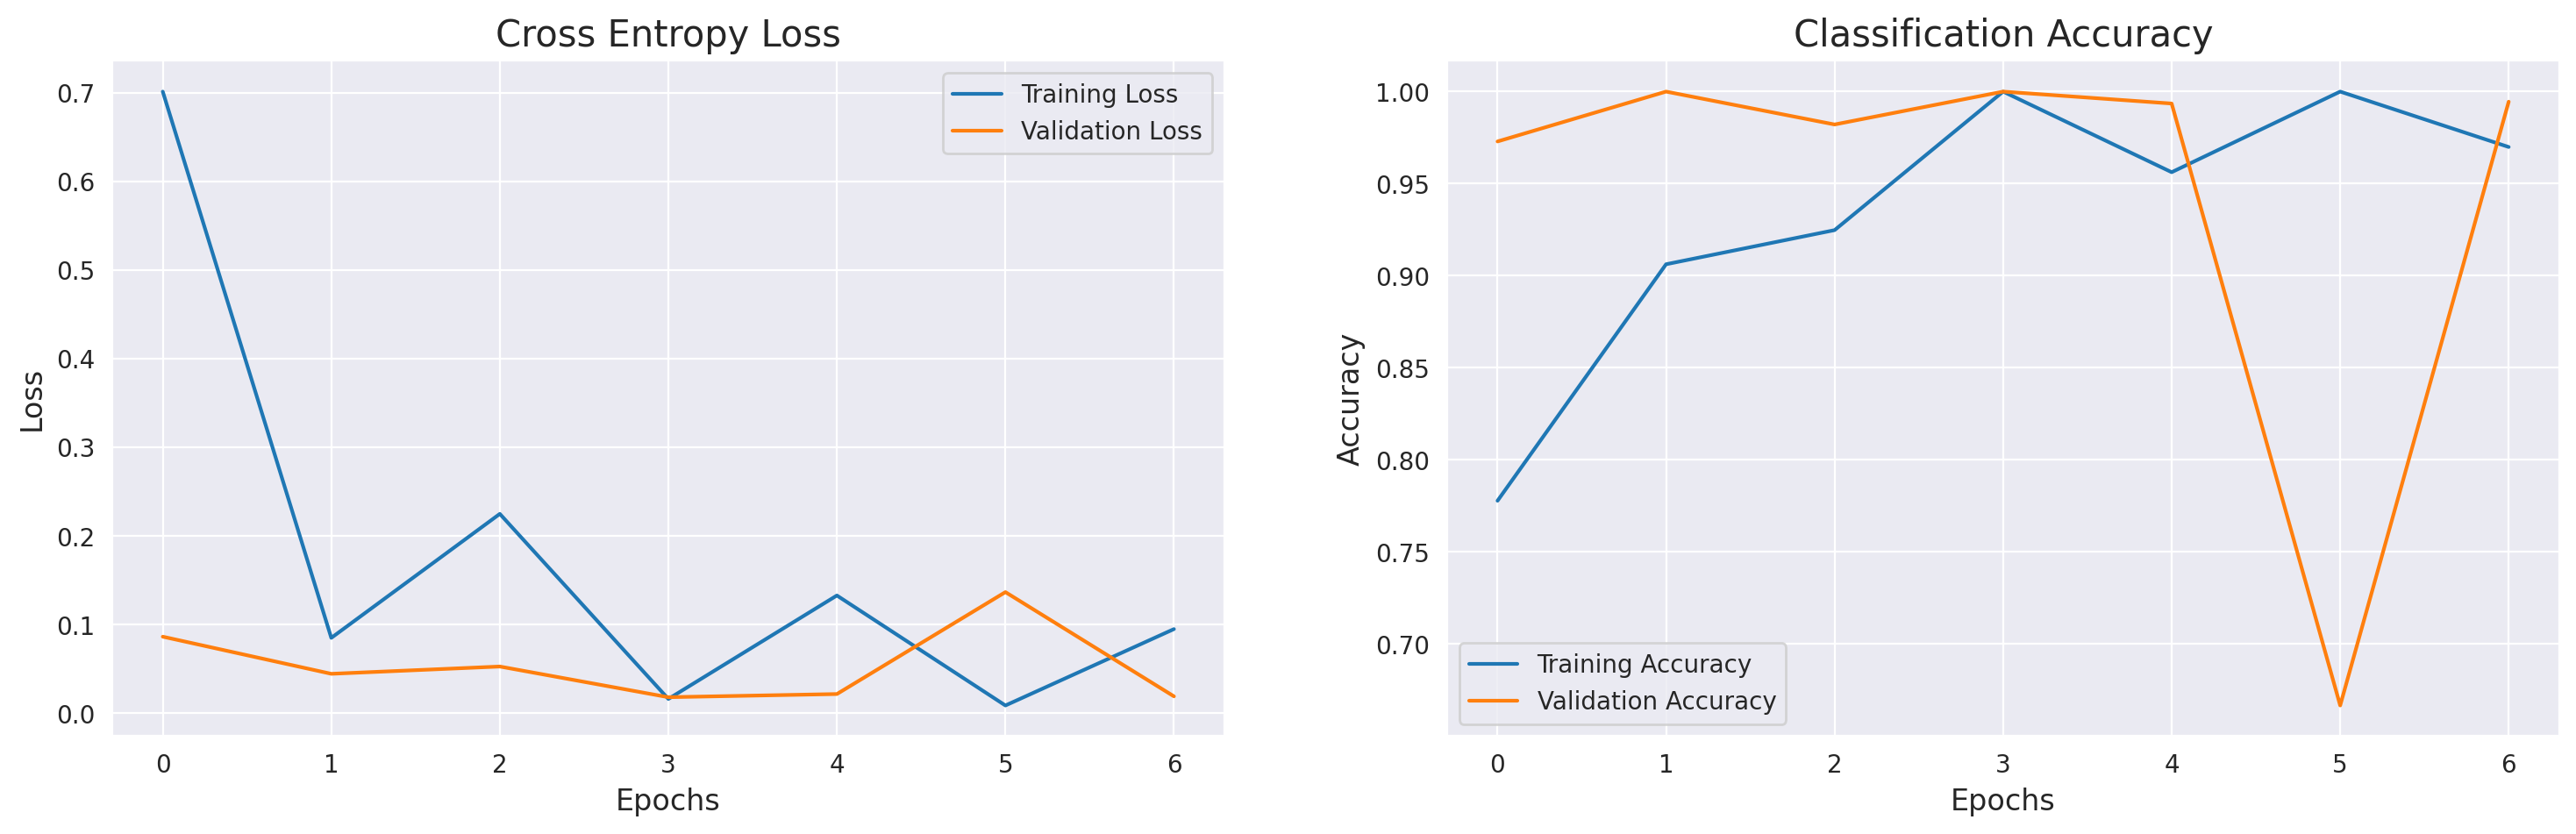


Plot the results done in : 0 h, 0 m, 0 s


In [16]:
# plots for accuracy and Loss with epochs
start_time = time.time()

error = pd.DataFrame(training_history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'], label='Training Loss')
plt.plot(error['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'], label='Training Accuracy')
plt.plot(error['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show(block=False)  # hosain : prevent the popup

calculate_and_print_time(start_time, 'Plot the results')

<h1> 9 - Evaluation <h1>

In [17]:
# 9 --------------------------------------------------------- Evaluation
# region
# @title 9 - Evaluation { display-mode: "form" }
# Evaluvate for train generator
start_time = time.time()

loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

calculate_and_print_time(start_time, 'Evaluation')

#  endregion

#

The accuracy of the model for training data is: 97.0039963722229
The Loss of the model for training data is: 0.09457273781299591
The accuracy of the model for validation data is: 98.30142259597778
The Loss of the model for validation data is: 0.05247294530272484

Evaluation done in : 0 h, 2 m, 2 s


<h1> 10 - save the model <h1>

In [18]:
# 10 --------------------------------------------------------- save the model
# region
# @title 10 - save the model { display-mode: "form" }
start_time = time.time()
model_name = 'model ' + 'img_size_' + str(image_size) + '.keras'
model.save(model_name)
# save the labels of the classes ,with same order they appear in confusion matrix,
#  to print the label of the predicted class when using the model

class_indices = train_generator.class_indices
index_to_label = {index: label for label, index in class_indices.items()}
created_json_file_name = f'index_to_label img_size_{image_size}.json'

with open(created_json_file_name, 'w', encoding='utf-8') as f:
    json.dump(index_to_label, f, ensure_ascii=False)


calculate_and_print_time(start_time, 'saving the model')
# endregion

#


saving the model done in : 0 h, 0 m, 0 s


<h1> 11 - Prediction <h1>

In [19]:
# 11 --------------------------------------------------------- Prediction
# region
# @title 11 - Prediction { display-mode: "form" }
start_time = time.time()
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)
y_pred = np.argmax(result, axis = 1)
y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)
print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)
calculate_and_print_time(start_time, 'Prediction')

# endregion

#

The accuracy of the model for testing data is: 98.41658473014832
The Loss of the model for testing data is: 0.055880315601825714

Prediction done in : 0 h, 0 m, 37 s


<h1> 12 - Classification Report <h1>

In [20]:
# 12 --------------------------------------------------------- Classification Report
# region
# @title 12 - Classification Report { display-mode: "form" }
start_time = time.time()

print("all entities names:", all_entities_names)
print(classification_report(y_true, y_pred,target_names=all_entities_names))

calculate_and_print_time(start_time , 'Classification Report')

# endregion

#

all entities names: ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']
              precision    recall  f1-score   support

           ا       0.99      1.00      0.99       248
           ب       0.99      0.99      0.99       248
           ت       0.99      0.80      0.88       248
           ث       0.81      0.99      0.89       248
           ج       1.00      1.00      1.00       248
           ح       1.00      1.00      1.00       248
           خ       1.00      0.96      0.98       249
           د       0.99      1.00      1.00       249
           ذ       1.00      1.00      1.00       248
           ر       1.00      0.99      0.99       248
           ز       0.98      1.00      0.99       248
           س       1.00      0.99      1.00       248
           ش       1.00      1.00      1.00       248
           ص       0.98      0.99      0.99       248
           ض       0.97     

<h1> 13 - Confusion Matrix <h1>

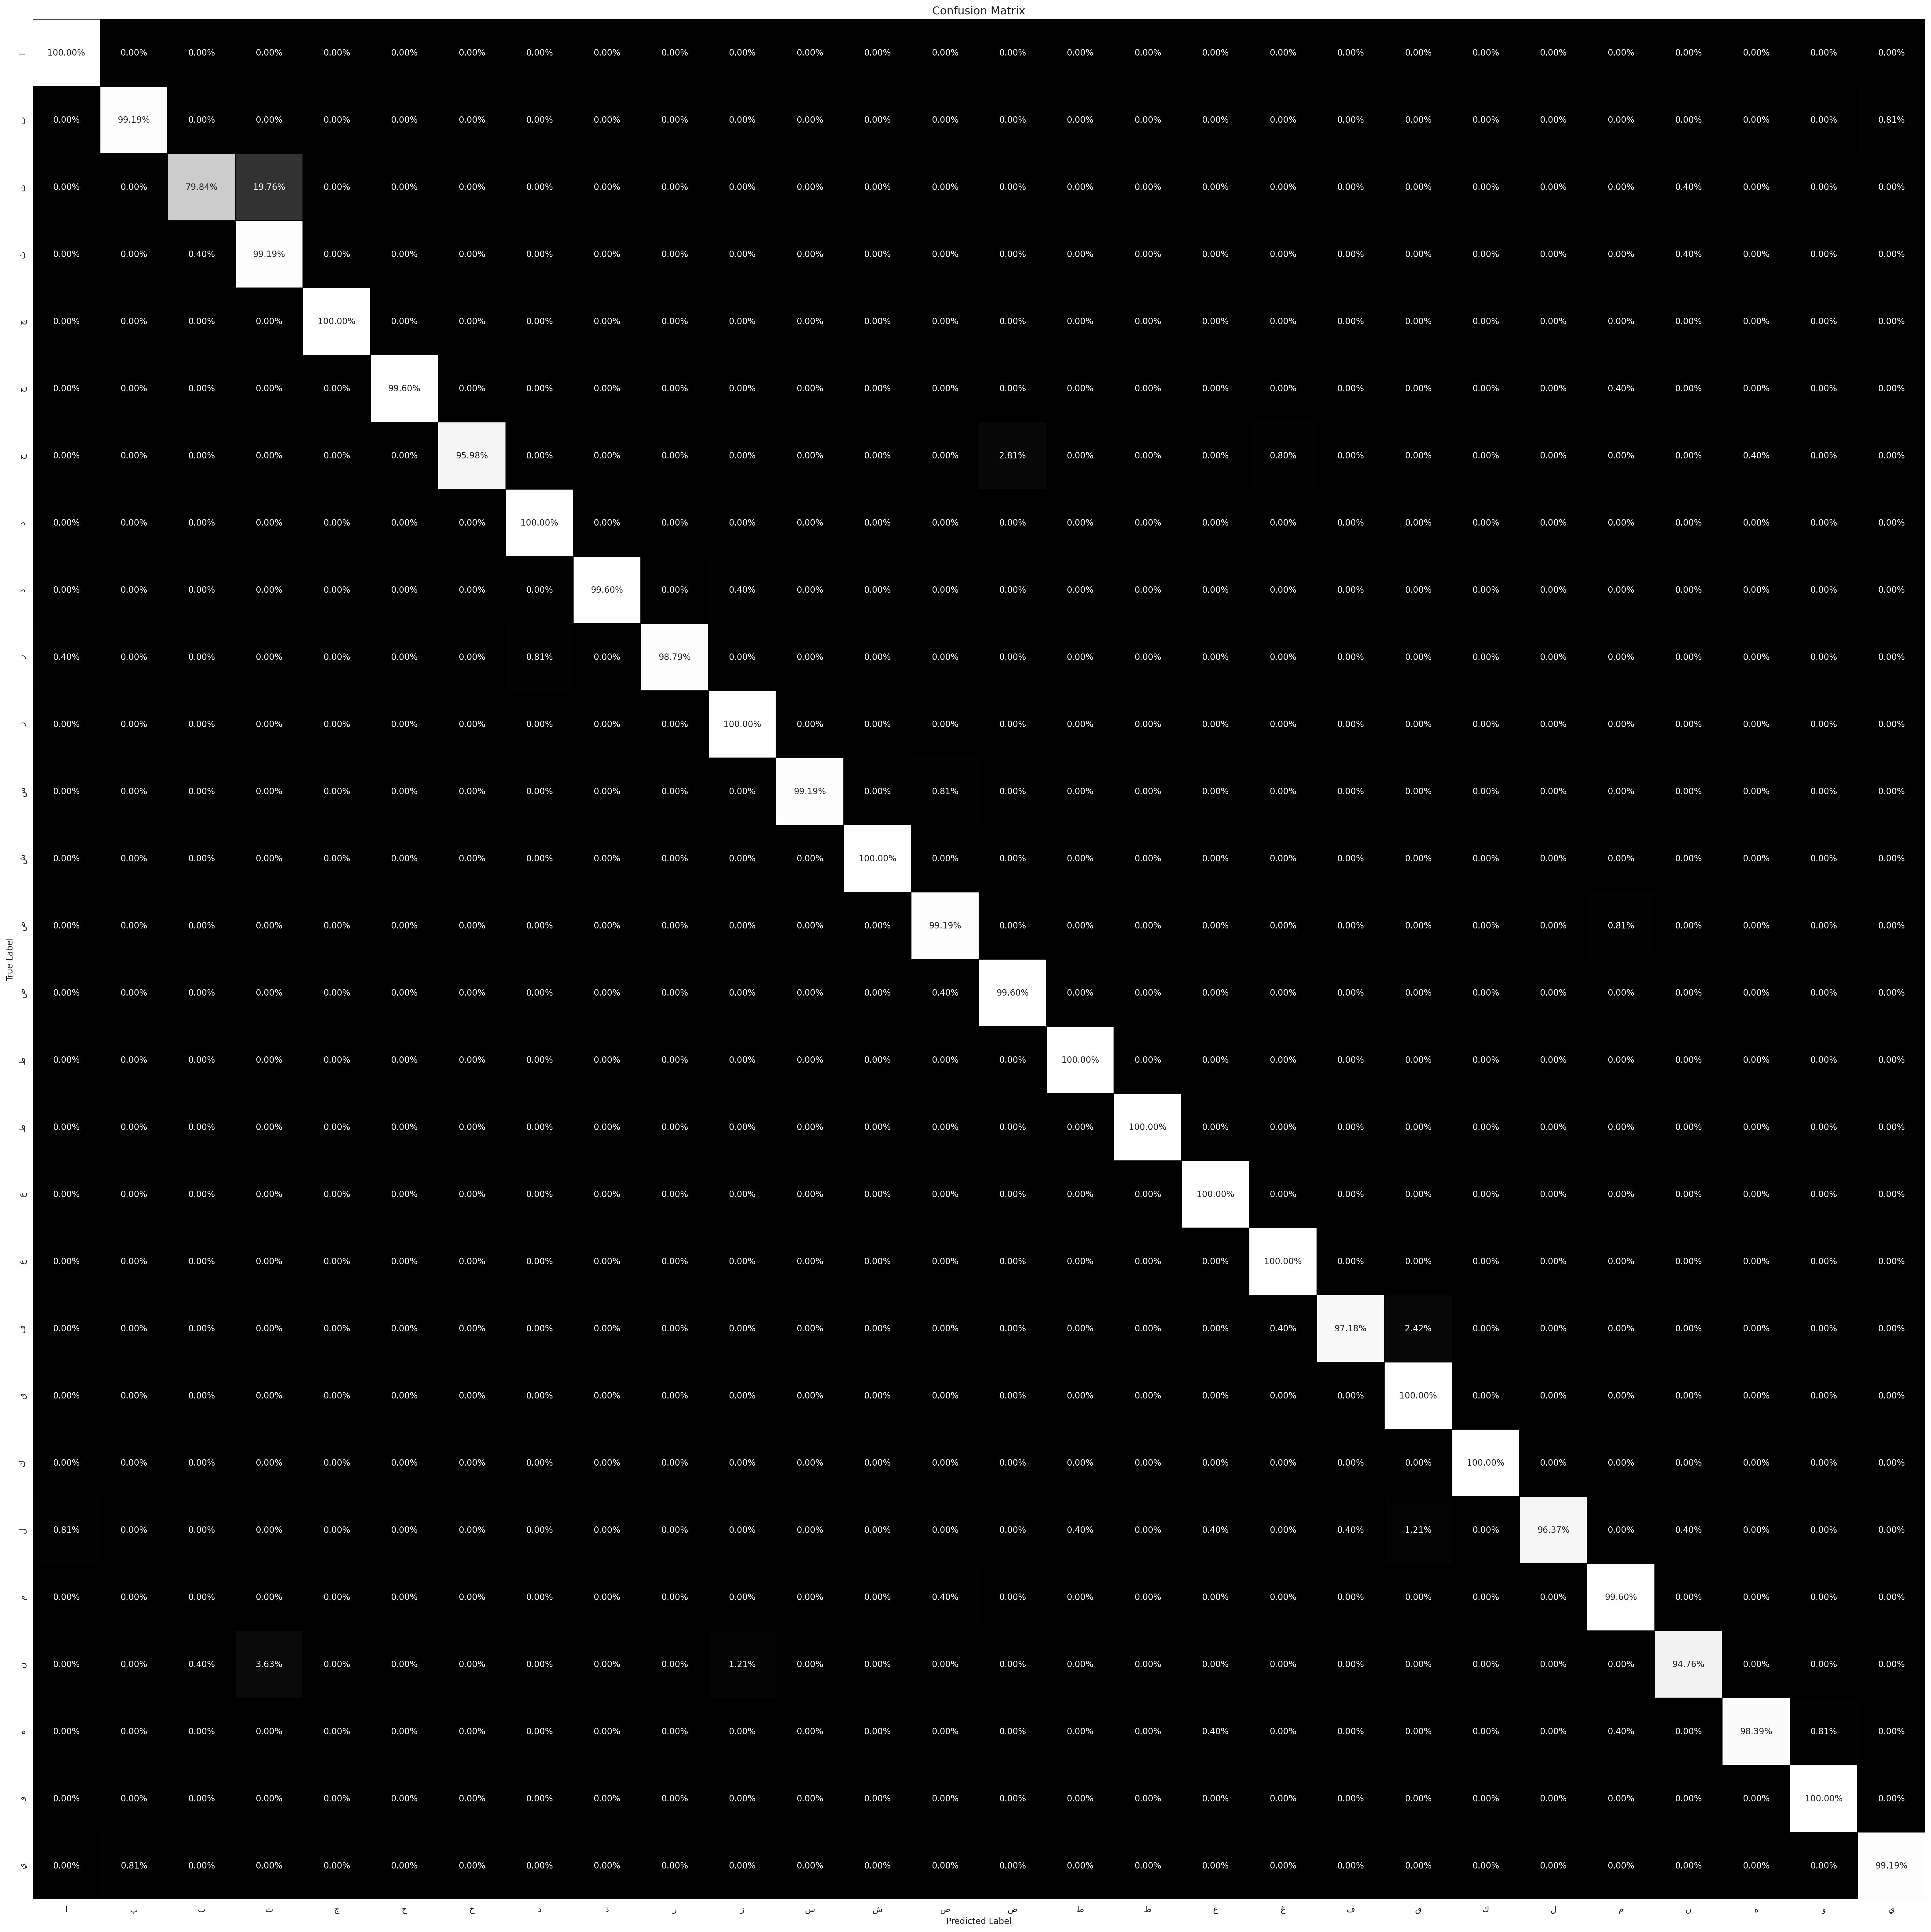

Accuracy for class ( ا ) : 100.00%

Accuracy for class ( ب ) : 99.19%
Class (ب) was wrongly seen as class (ي) in 0.81% of cases

Accuracy for class ( ت ) : 79.84%
Class (ت) was wrongly seen as class (ث) in 19.76% of cases
Class (ت) was wrongly seen as class (ن) in 0.40% of cases

Accuracy for class ( ث ) : 99.19%
Class (ث) was wrongly seen as class (ت) in 0.40% of cases
Class (ث) was wrongly seen as class (ن) in 0.40% of cases

Accuracy for class ( ج ) : 100.00%

Accuracy for class ( ح ) : 99.60%
Class (ح) was wrongly seen as class (م) in 0.40% of cases

Accuracy for class ( خ ) : 95.98%
Class (خ) was wrongly seen as class (ض) in 2.81% of cases
Class (خ) was wrongly seen as class (غ) in 0.80% of cases
Class (خ) was wrongly seen as class (ه) in 0.40% of cases

Accuracy for class ( د ) : 100.00%

Accuracy for class ( ذ ) : 99.60%
Class (ذ) was wrongly seen as class (ز) in 0.40% of cases

Accuracy for class ( ر ) : 98.79%
Class (ر) was wrongly seen as class (ا) in 0.40% of cases
Class (ر)

In [21]:

# 13 --------------------------------------------------------- Confusion Matrix
# Normalize the confusion matrix
# region
# @title 13 - Confusion Matrix { display-mode: "form" }
start_time = time.time()

confusion_mtx = confusion_matrix(y_true, y_pred)
confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

num_classes = confusion_mtx.shape[0]
figsize = 40  # adjust as needed

f, ax = plt.subplots(figsize=(figsize, figsize), dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap="gist_yarg_r", linecolor="black", fmt='.2%', ax=ax, cbar=False, xticklabels=all_entities_names, yticklabels=all_entities_names)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=13)

plt.show()


# Print accuracy for each class
for i in range(num_classes):
    true_positives = confusion_mtx[i, i]
    accuracy = true_positives * 100  # convert to percentage
    print(f"Accuracy for class ( {all_entities_names[i]} ) : {accuracy:.2f}%")

    # Print confusion with other classes
    for j in range(num_classes):
        if i != j and confusion_mtx[i, j] > 0:
            confusion = confusion_mtx[i, j] * 100  # convert to percentage
            print(f"Class ({all_entities_names[i]}) was wrongly seen as class ({all_entities_names[j]}) in {confusion:.2f}% of cases")
    print()        

calculate_and_print_time(start_time , 'Confusion Matrix')

# endregion 

<h1> 14 - Execution Time <h1>

In [22]:
# 14 --------------------------------------------------------- Execution Time
# region
# @title 14 - Execution time  { display-mode: "form" }

calculate_and_print_time(global_start_time , 'Whole notebook execution time')





Whole notebook execution time done in : 0 h, 16 m, 57 s
